### INTEGER PROGRAMMING MODEL FOR A SOLAR PANEL MANUFACTURER SEEKING A COST EFFECTIVE DISTRIBUTION NETWORK 

In [28]:
#========================================
# libraries used in mode 
#========================================

import folium as fl # allows creating geogeografic maps
import random as rm # random numbers to create data
import pandas as pd # dataframes
from pulp import * # IP, LP or MIP optimization models

### MAP WITH AVAILABLE WAREHOUSES (ORIGIN NODES) IN THE NETWORK

In [29]:
#------------------------------------------------
# Folium map takes two arguments 
# * location: --> [latitude, longitude]
# * zoom
# * I obtained the location latitude and longitude
# from https://www.latlong.net/
#------------------------------------------------
map = fl.Map(location=[40.964863,-104.775263], zoom_start=5)
fl.Marker(location=[33.830302, -116.546843], popup="Palms Springs, CA", icon=fl.Icon(color='green')).add_to(map)
fl.Marker(location=[38.581573, -121.494400], popup="Sacramento, CA", icon=fl.Icon(color='green')).add_to(map)
fl.Marker(location=[29.759935, -95.364238], popup="Huston, TX",icon=fl.Icon(color='green')).add_to(map)
fl.Marker(location=[41.588821, -93.620308], popup="Des Moines, IO",icon=fl.Icon(color='green')).add_to(map)
fl.Marker(location=[33.748997, -84.387985], popup="Atlanta, GA",icon=fl.Icon(color='green')).add_to(map)
fl.Marker(location=[39.952583, -75.165222], popup="Philadelphia, PA",icon=fl.Icon(color='green')).add_to(map)
map



### CREATING LIST OF WAREHOUSES AND CUSTOMERS 


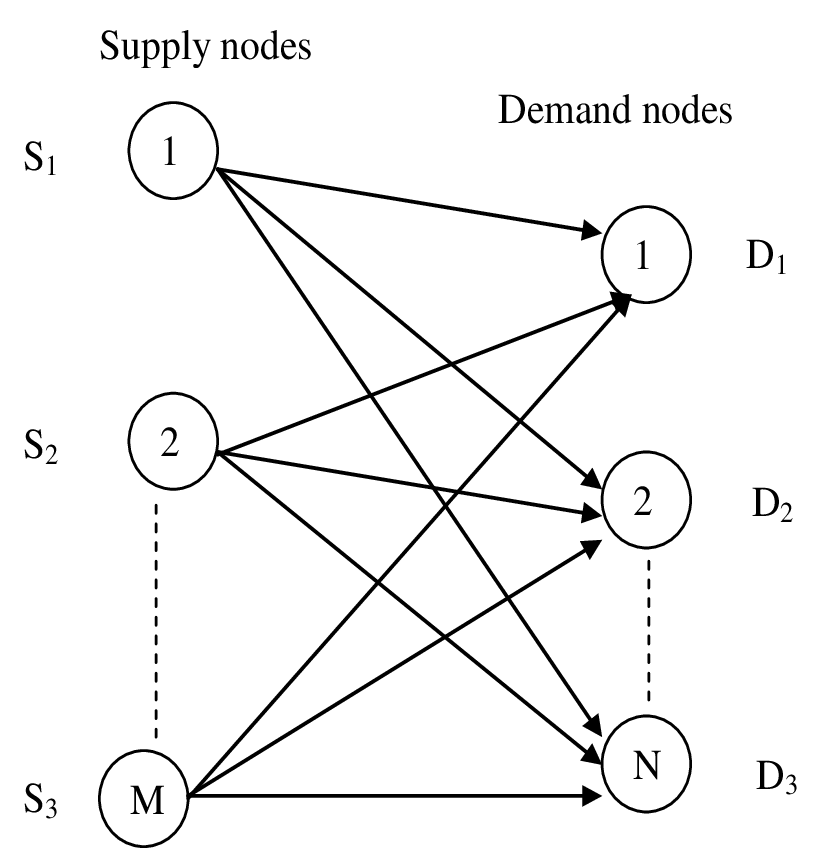

The supply chain network currently has 6 warehouses available to ship from. When modeling a transportation problem, we usually refer to these as the supply nodes. The supply nodes are supposed to serve 10 customers in the network. Customers are often referred to as the demand node. The arcs in the middle is what we aim to optimize.

In [30]:
#========================================================================
# creating a list of available warehouses in the network [SUPPLY NODE]
#========================================================================
warehouses = ['Palm Springs','Sacramento','Huston','Atlanta','Des Moines','Philadelpia']
#========================================================================
# creating a list of customers in the network [DEMAND NODE]
#========================================================================
customers = ['Chicago','St George','Gary','Madison','Buffalo','Tampa','New Orleans','Denver','Phoemix','New Milford']

The data utilized in this project is purely synthetic using random number methods from python 'random' library. 
* There are 10 Demand Nodes in the supply chain 
    * Assume that as a minimum customers can order 50,000 units of solar panels 
    * At maximum 300,000 units 
------------
10 random values in the range of 50,000 and 300,000 were generated to simulate customer demand. In order to assign these values to customers I created a dictionary that will take customers as key and demand as value.

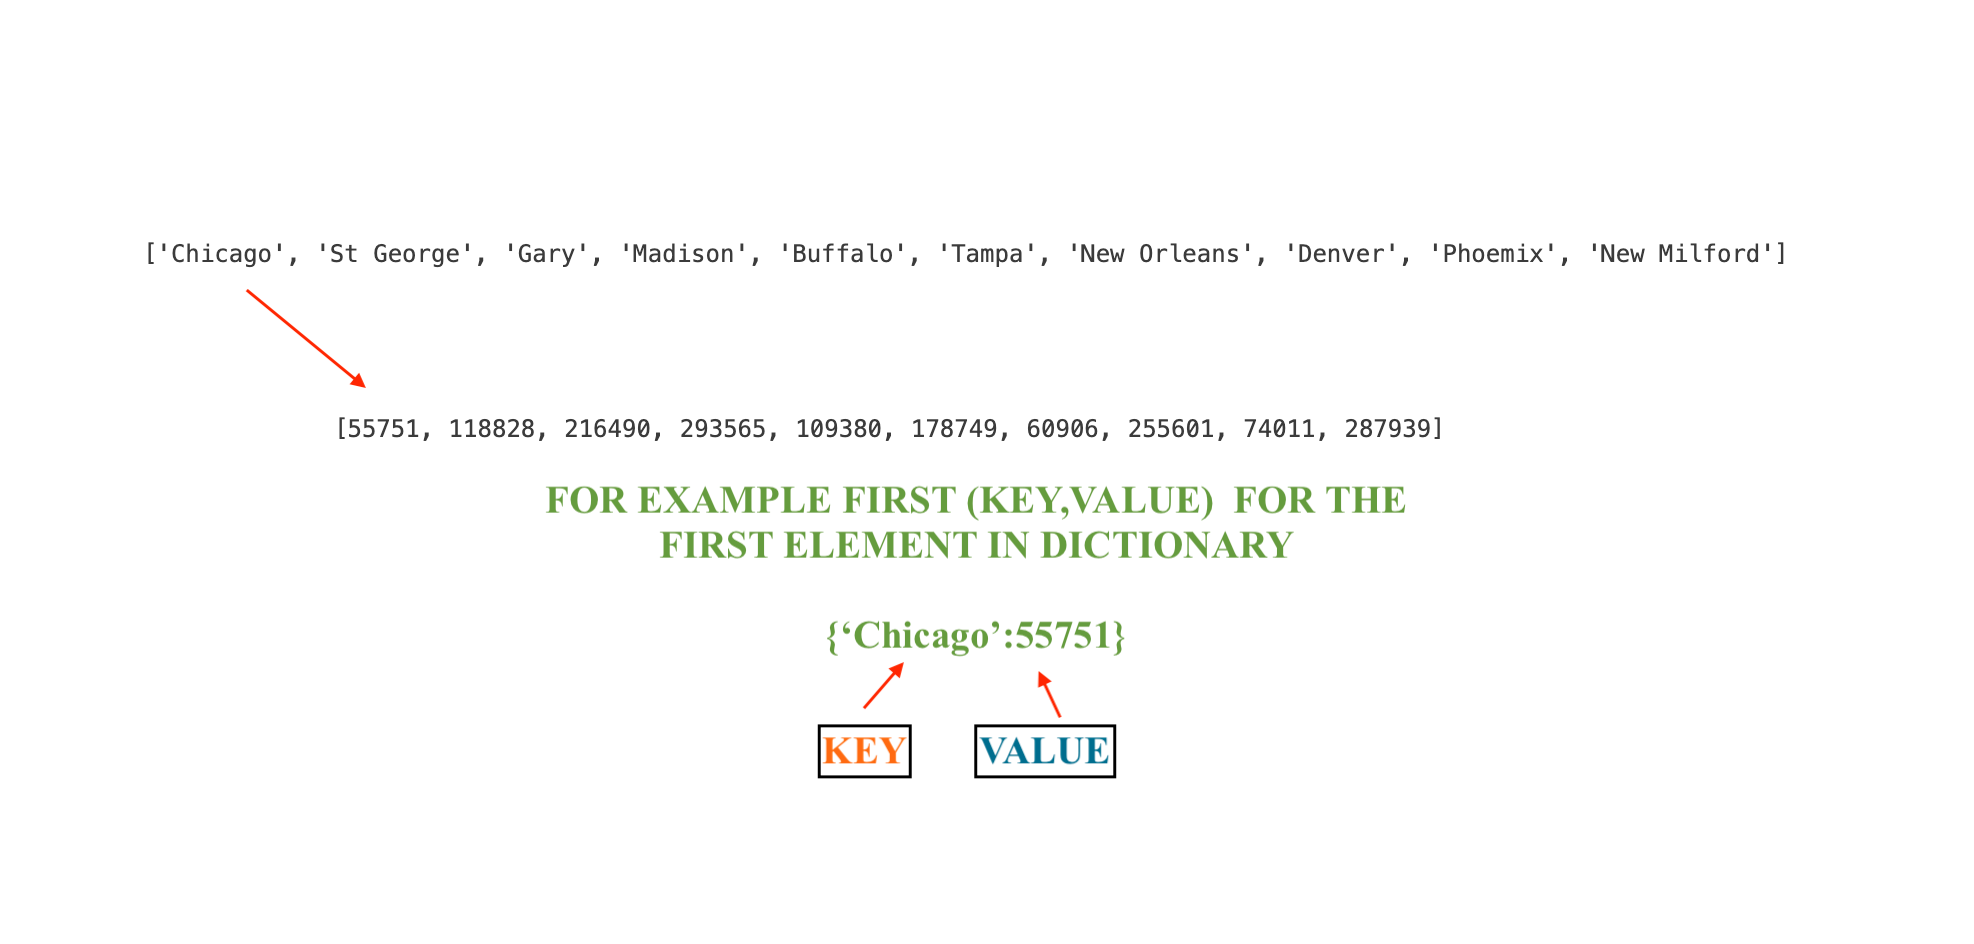

In [31]:
#=====================================================
# generating random numbers to simulate monthy demand
#=====================================================
n = 10 
demand = rm.sample(range(50000,300000), n)
customer_demand = dict(zip(customers, demand))

### BAR PLOT AND SUMMARY STATISTICS OF CUSTOMER DEMAND

<Axes: title={'center': 'Customer Demand'}, xlabel='Customer'>

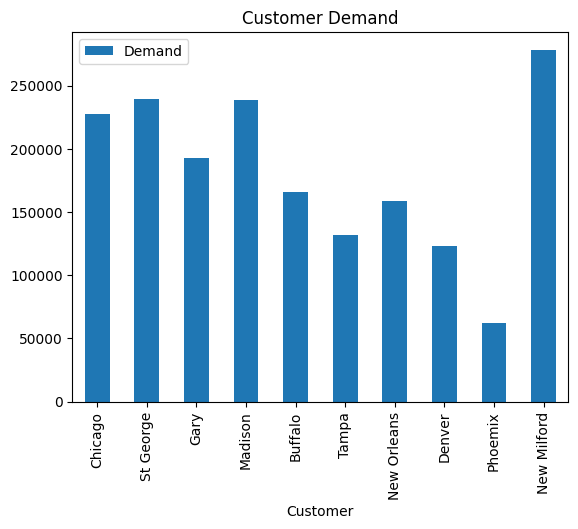

In [32]:
#================================================================================
# Creating a dataframe of customer demand for visualization and stats purposes 
#=================================================================================
customer_demand_dataframe = pd.DataFrame(list(customer_demand.items()), columns=['Customer', 'Demand'])
#================================================================================
# Creating a barplot
#=================================================================================
customer_demand_dataframe.plot(kind='bar', x='Customer', y='Demand', title='Customer Demand')

* SUMMARY 
    * By observing the bar plot customers with the higher demand appaar to be -->
        * Chicago
        * St George 
        * Denver 
        * New Mildford 
    * Customers with the lowest demand 
        * Tampa 
        * Gary 
        * Madison

* SUMMARY STATISTICS 
    * The average demand appears to be 133,156 units with a standard deviation of 61186 units 
    * The minimum demand amoung the 10 customers appears to be of 51521 units 
    * The maximum demand 216,539 units 

In [33]:
customer_demand_dataframe['Demand'].describe()

count        10.000000
mean     181806.100000
std       66007.557061
min       62009.000000
25%      138383.250000
50%      179275.000000
75%      235825.250000
max      278476.000000
Name: Demand, dtype: float64

### SETTING SHIPPING PRICE FOR UNIT

Most residential panels measuring about 5.5 feet by 3 feet and weighing between 40 and 50 pounds.  
[https://www.energysage.com/solar/average-solar-panel-size-weight/]


* AVERAGE PRICE FOR 50LB PACKAGE [https://redstagfulfillment.com/cheapest-way-to-ship-50-lb-package/]

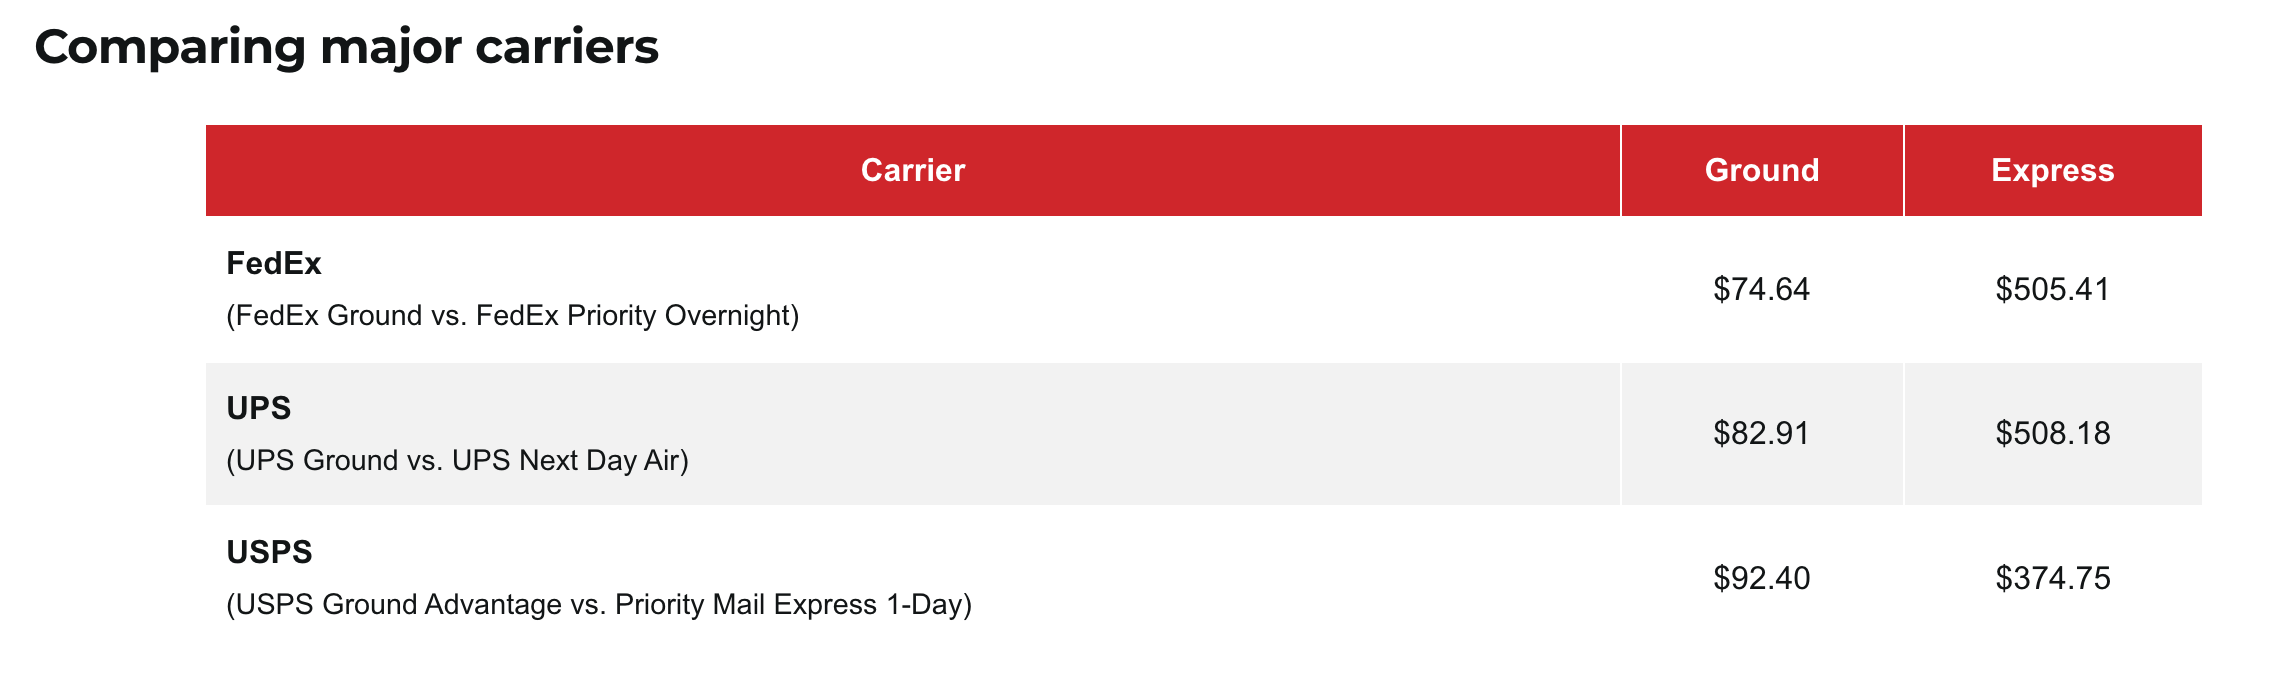


Considering there are currently 10 customers and 6 available warehouses we need 60 shipping prices. I generated them taking into consideration prices from different carriers for a 50lb package. The price range is $75 and $95 per unit. 
Then created a dictionary giving a combination of warehouse, customer as the key and shipping price as value. This dictionary will be a crucial component of the objective function.

In [34]:
n_p=60
shipping_prices = rm.choices(range(70,95), k=n_p)
key = [(w,c) for w in warehouses for c in customers]
cost_dict = dict(zip(key, shipping_prices))
cost_dict

{('Palm Springs', 'Chicago'): 94,
 ('Palm Springs', 'St George'): 84,
 ('Palm Springs', 'Gary'): 83,
 ('Palm Springs', 'Madison'): 94,
 ('Palm Springs', 'Buffalo'): 73,
 ('Palm Springs', 'Tampa'): 86,
 ('Palm Springs', 'New Orleans'): 77,
 ('Palm Springs', 'Denver'): 81,
 ('Palm Springs', 'Phoemix'): 82,
 ('Palm Springs', 'New Milford'): 81,
 ('Sacramento', 'Chicago'): 89,
 ('Sacramento', 'St George'): 72,
 ('Sacramento', 'Gary'): 84,
 ('Sacramento', 'Madison'): 72,
 ('Sacramento', 'Buffalo'): 76,
 ('Sacramento', 'Tampa'): 88,
 ('Sacramento', 'New Orleans'): 92,
 ('Sacramento', 'Denver'): 84,
 ('Sacramento', 'Phoemix'): 88,
 ('Sacramento', 'New Milford'): 92,
 ('Huston', 'Chicago'): 78,
 ('Huston', 'St George'): 85,
 ('Huston', 'Gary'): 77,
 ('Huston', 'Madison'): 75,
 ('Huston', 'Buffalo'): 79,
 ('Huston', 'Tampa'): 88,
 ('Huston', 'New Orleans'): 90,
 ('Huston', 'Denver'): 88,
 ('Huston', 'Phoemix'): 75,
 ('Huston', 'New Milford'): 80,
 ('Atlanta', 'Chicago'): 71,
 ('Atlanta', 'St Ge

### BUILDING MODEL

* Initializing the model 

    * Model Objective --> 

        * When initilizing the model is important to undertand the objective, in this case we want to minimize the cost associacited with transportation. 
        
        * The model has been named "Minimize Shipping Costs" and its a minimization model therefore -> LpMinimize

In [35]:

# Initialize Model
model = LpProblem("Minimize Shipping Costs", LpMinimize)

/workspaces/supply_chain_optimization_models/.conda/lib/python3.12/site-packages/pulp/pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


### DECISION VARIABLES 

* Decision variables are the controllable inputs. In this case is each possible combination of supply node and demand node.

* I created a key (w,c) with the combination of each warehouse with each customer. 

* PuLP offers  LpVariable.dicts() where we can create multiple decision variables in a dictionary format. 

* The value of the dictionary will eventually hold the optimal number of units to ship from a demand node to a supply node once the problem has been solved. 

$$
w=\{1,2,3...6\}
$$

$$
c=\{1,2,3...10\}
$$

$$
X(w,c) \geq0
$$

THIS IS AN INTEGER PROGRAMMING PROBLEM MEANING THE LOWERBOUND OF X(w,c) MUST BE GREATER THAN OR EQUAL TO 0. WE CANNOT SHIP NEGATIVE QTY'S OF SOLAR PANELS

In [36]:
# Define decision variables
key = [(w, c) for w in warehouses for c in customers]
var_dict = LpVariable.dicts('num_of_shipments', 
                            key, 
                            lowBound=0, cat='Integer')

### OBJECTIVE FUNCTION


* The objective function is concerned with optimizing the arcs between supply and demand nodes. 

* The function can be denoted as follows
$$
min \sum{S{(w,c)}X(w,c)}
$$

* Where => 
    * S(w,c) is the shipping cost associated with the combination of supply and demand node 

    * X(w,c) is the decision variable 

lpSum -> sums all the costs associated with fullfiling all custumers 

In [37]:
model += lpSum([cost_dict[(w, c)] * var_dict[(w, c)] 
                for w in warehouses for c in customers])

### CONSTRAINTS

* Constrains are uncontrollable inputs in the model.

* In this model the only contrain is concerned with meeting customer demand - therefore the sum of shipped qty's must be equal to customer demand

$$
\sum{X(w,c)} \geq {d_c}
$$

* Where -> 

    * X(w,c) -> is the decision variable 

    * d_c -> customer demand 

In [38]:
for c in customers:
    model += lpSum([var_dict[(w,c)] for w in warehouses]) == customer_demand[c]

### SOLVING MODEL

* Once we have defined 
    * Decision Variable 
    * Objective function 
    * Constraints 

Solving the model is straightforward we simple call model.solve()

* MODEL STATUS 
    * Checking the model status is important since we can get 3 possible outcomes 

        * Not Solved 

        * Optimal  --> [we want this to be our outcome.]

        * Infeasible 

We want an 'OPTIMAL' solution meaning the solver has found a solution that is optimal for the presented problem.

In [39]:
model.solve()

# Print the Model Status
print("Model Status: {}".format(LpStatus[model.status]))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /workspaces/supply_chain_optimization_models/.conda/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/b9d81844e467432fb46beba04e73c66e-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/b9d81844e467432fb46beba04e73c66e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 15 COLUMNS
At line 256 RHS
At line 267 BOUNDS
At line 328 ENDATA
Problem MODEL has 10 rows, 60 columns and 60 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1.3272e+08 - 0.00 seconds
Cgl0004I processed model has 0 rows, 0 columns (0 integer (0 of which binary)) and 0 elements
Cbc3007W No integer variables - nothing to do
Cuts at root node changed objective from 1.3272e+08 to -1.79769e+308
Probing was tried 0 times and created 0 cuts of which 0 were active after adding rounds of cuts 

In this case the model has found an optimal solution to the Linear Problem 

### MODEL DECISION VARIABLES 

In [40]:
# Print the Decision Variables
for v in model.variables():
    print(v.name, "=", v.varValue)

num_of_shipments_('Atlanta',_'Buffalo') = 0.0
num_of_shipments_('Atlanta',_'Chicago') = 227876.0
num_of_shipments_('Atlanta',_'Denver') = 0.0
num_of_shipments_('Atlanta',_'Gary') = 0.0
num_of_shipments_('Atlanta',_'Madison') = 0.0
num_of_shipments_('Atlanta',_'New_Milford') = 0.0
num_of_shipments_('Atlanta',_'New_Orleans') = 0.0
num_of_shipments_('Atlanta',_'Phoemix') = 62009.0
num_of_shipments_('Atlanta',_'St_George') = 0.0
num_of_shipments_('Atlanta',_'Tampa') = 0.0
num_of_shipments_('Des_Moines',_'Buffalo') = 0.0
num_of_shipments_('Des_Moines',_'Chicago') = 0.0
num_of_shipments_('Des_Moines',_'Denver') = 123004.0
num_of_shipments_('Des_Moines',_'Gary') = 0.0
num_of_shipments_('Des_Moines',_'Madison') = 0.0
num_of_shipments_('Des_Moines',_'New_Milford') = 0.0
num_of_shipments_('Des_Moines',_'New_Orleans') = 158841.0
num_of_shipments_('Des_Moines',_'Phoemix') = 0.0
num_of_shipments_('Des_Moines',_'St_George') = 0.0
num_of_shipments_('Des_Moines',_'Tampa') = 131564.0
num_of_shipments_(

In [41]:
# Print the Decision Variables
print ("===================================================")
print("\t\tOPTIMAL ARCS")
print ("===================================================")
for v in model.variables():
    if v.varValue >= 1:
        variable.append(v.name)
        qty.append(v.varValue)
        print(v.name, "=", v.varValue)

		OPTIMAL ARCS
num_of_shipments_('Atlanta',_'Chicago') = 227876.0
num_of_shipments_('Atlanta',_'Phoemix') = 62009.0
num_of_shipments_('Des_Moines',_'Denver') = 123004.0
num_of_shipments_('Des_Moines',_'New_Orleans') = 158841.0
num_of_shipments_('Des_Moines',_'Tampa') = 131564.0
num_of_shipments_('Huston',_'Gary') = 192672.0
num_of_shipments_('Philadelpia',_'Buffalo') = 165878.0
num_of_shipments_('Philadelpia',_'New_Milford') = 278476.0
num_of_shipments_('Sacramento',_'Madison') = 238475.0
num_of_shipments_('Sacramento',_'St_George') = 239266.0


* SUMMARY 
    * Most cost effective supply nodes 
        * Atlanta 
        * Des Moines 
        * Huston
        * Philadelpia 
        * Sacramento
    * supply node not considered in optimized model
        * Palms Springs, CA

### OBJECTIVE VALUE

* The objective value will provide the sum of shipping costs from the optimized arcs 

In [42]:
# Print the Objective Value
print("=============================================================")
print("Objective [TOTAL SHIPPING COSTS] = ", value(model.objective))
print("=============================================================")

Objective [TOTAL SHIPPING COSTS] =  132719600.0


### SENSITIVITY ANALYSIS 

- shadow price
    - represents changes in total cost associated with a unit increase in demand in a given region
- slack
    - should be = 0

In [43]:
# Print the Constraint Slack
o = [{'name':name, 'shadow price':c.pi,'slack':c.slack} 
     for name, c in model.constraints.items()]
o_df = pd.DataFrame(o)
o_df

,name,shadow price,slack
0,_C1,0.0,-0.0
1,_C2,0.0,-0.0
2,_C3,0.0,-0.0
3,_C4,0.0,-0.0
4,_C5,0.0,-0.0
5,_C6,0.0,-0.0
6,_C7,0.0,-0.0
7,_C8,0.0,-0.0
8,_C9,0.0,-0.0
9,_C10,0.0,-0.0
